# 1 - Perkenalan

Nama : Nurul Izzah

Batch : 018

Dataset : Brain MRI Images

Objective : Brain Tumor Detection

# 2 - Import Libraries

In [1]:
# import library yg digunakan
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from PIL import Image
import os
import cv2
import shutil

from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.model_selection import KFold
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense, Flatten, Conv2D, MaxPooling2D, Dropout, Reshape, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import VGG16

import pickle
import json

import warnings
warnings.filterwarnings(action='ignore')

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# 3 - Data Loading

In [3]:
#memasukan path file data gambar
data_path = '/content/drive/MyDrive/dataset/brain_tumor_dataset'

In [4]:
#Path ke folder
tumor_path = os.path.join(data_path, 'yes') 
non_tumor_path = os.path.join(data_path, 'no')

In [5]:
#melihat list gambar dari setiap folder
print('List of images in tumor_path: ')
for file in os.listdir(tumor_path):
  print(file)
  
print('List of images in non_tumor_path: ')
for file in os.listdir(non_tumor_path):
  print(file)

List of images in tumor_path: 
Y41.jpg
Y243.JPG
Y255.JPG
Y167.JPG
Y79.jpg
Y105.jpg
Y154.jpg
Y55.jpg
Y97.JPG
Y34.jpg
Y45.JPG
Y166.JPG
Y75.JPG
Y111.JPG
Y256.JPG
Y182.JPG
Y50.JPG
Y185.jpg
Y35.jpg
Y49.JPG
Y148.JPG
Y22.jpg
Y92.jpg
Y27.jpg
Y23.JPG
Y165.JPG
Y101.jpg
Y86.JPG
Y20.jpg
Y246.JPG
Y96.jpg
Y62.jpg
Y192.JPG
Y193.JPG
Y76.jpg
Y195.JPG
Y24.jpg
Y60.jpg
Y104.jpg
Y162.jpg
Y120.JPG
Y114.JPG
Y61.jpg
Y160.JPG
Y158.JPG
Y91.jpg
Y70.jpg
Y113.JPG
Y109.JPG
Y59.JPG
Y17.jpg
Y28.jpg
Y259.JPG
Y155.JPG
Y99.JPG
Y103.jpg
Y82.jpg
Y71.JPG
Y85.JPG
Y153.jpg
Y73.jpg
Y159.JPG
Y25.jpg
Y188.jpg
Y107.jpg
Y37.jpg
Y161.JPG
Y170.JPG
Y18.JPG
Y21.jpg
Y46.jpg
Y47.JPG
Y44.JPG
Y164.JPG
Y194.jpg
Y169.jpg
Y253.JPG
Y9.jpg
Y7.jpg
Y19.JPG
Y250.jpg
Y247.JPG
Y74.jpg
Y16.JPG
Y254.jpg
Y58.JPG
Y184.JPG
Y77.jpg
Y1.jpg
Y36.JPG
Y249.JPG
Y108.jpg
Y100.JPG
Y146.JPG
Y32.jpg
Y8.jpg
Y38.jpg
Y6.jpg
Y56.jpg
Y14.jpg
Y2.jpg
Y244.JPG
Y168.jpg
Y163.JPG
Y187.jpg
Y39.jpg
Y30.jpg
Y248.JPG
Y95.jpg
Y52.jpg
Y102.jpg
Y147.JPG
Y3.jpg
Y31.jpg
Y258.JPG
Y4

# 4 - Exploratory Data Analysis (EDA)

> Melihat jumlah data gambar pada setiap folder

In [6]:
# menghitung jumlah gambar dalam folder tumor
data_tumor_files = os.listdir(tumor_path)
num_data_tumor = len(data_tumor_files)
print(f"Jumlah gambar dalam folder tumor: {num_data_tumor}")

# menghitung jumlah gambar dalam folder non-tumor
data_non_tumor_files = os.listdir(non_tumor_path)
num_data_non_tumor = len(data_non_tumor_files)
print(f"Jumlah gambar dalam folder non-tumor: {num_data_non_tumor}")

Jumlah gambar dalam folder tumor: 408
Jumlah gambar dalam folder non-tumor: 98


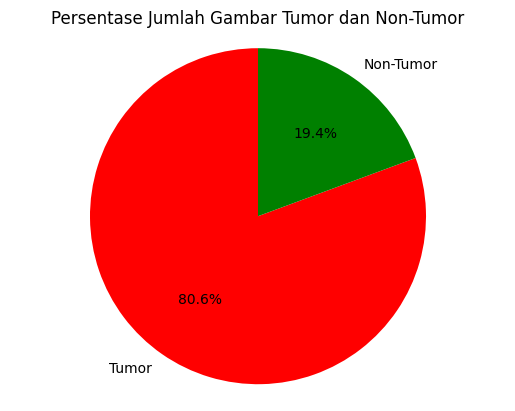

In [7]:
# membuat visualisasi
labels = ['Tumor', 'Non-Tumor']
sizes = [num_data_tumor, num_data_non_tumor]
colors = ['red', 'green']

plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
plt.axis('equal')
plt.title('Persentase Jumlah Gambar Tumor dan Non-Tumor')
plt.show()

jumlah masing2 data gambar antara data yes dan no adalah 155 untuk data yes, dan 98 untuk data no, kesimpulannya, datanya imbalance

> Melihat ukuran gambar

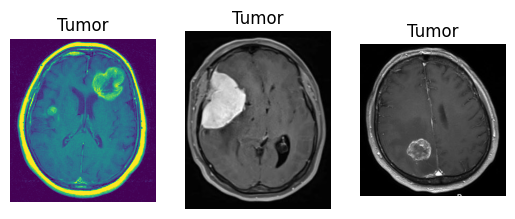

In [8]:
# Visualisasi beberapa sampel gambar dari folder tumor
tumor_samples = os.listdir(tumor_path)[:3]
for i, sample in enumerate(tumor_samples):
    sample_path = os.path.join(tumor_path, sample)
    img = Image.open(sample_path)
    plt.subplot(1, 3, i+1)
    plt.imshow(img)
    plt.title('Tumor')
    plt.axis('off')
plt.show()

terlihat digambarnya, tanda bulat bewarna putih adalah tumoornya dan memiliki ukuran yg bermacam-macam serta berada di posisi yg berbeda-beda

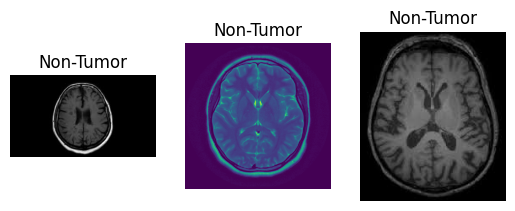

In [9]:
# Visualisasi beberapa sampel gambar dari folder non-tumor
non_tumor_samples = os.listdir(non_tumor_path)[:3]
for i, sample in enumerate(non_tumor_samples):
    sample_path = os.path.join(non_tumor_path, sample)
    img = Image.open(sample_path)
    plt.subplot(1, 3, i+1)
    plt.imshow(img)
    plt.title('Non-Tumor')
    plt.axis('off')
plt.show()

dan pada gambar non-tumor tidak ada perbedaan antara gambar satu dan lainnya

> menghitung ukuran gambar pada data gambar tumor dan non tumor

In [10]:
#Looping untuk menghitung ukuran gambar tumor
for img_file in os.listdir(tumor_path):
    img_path = os.path.join(tumor_path, img_file)
    img = cv2.imread(img_path)
    height, width, channels = img.shape
    gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Menghitung ringkasan dari ukuran gambar tumor
    size_mean = np.mean([height, width])
    size_std = np.std([height, width])
    size_min = np.min([height, width])
    size_max = np.max([height, width])

    #Menghitung ringkasan untuk nilai piksel
    pixel_mean = np.mean(gray_img)
    pixel_std = np.std(gray_img)
    pixel_min = np.min(gray_img)
    pixel_max = np.max(gray_img)

    #Menghitung pencerahan gambar
    brightness_mean = np.mean(img)
    brightness_std = np.std(img)
    brightness_min = np.min(img)
    brightness_max = np.max(img)

In [11]:
#menghitung hasil
print("Image: {} (tumor)".format(img_file))
print("Size: Mean={}, Std={}, Min={}, Max={}".format(size_mean, size_std, size_min, size_max))
print("Pixel Values: Mean={}, Std={}, Min={}, Max={}".format(pixel_mean, pixel_std, pixel_min, pixel_max))
print("Brightness: Mean={}, Std={}, Min={}, Max={}".format(brightness_mean, brightness_std, brightness_min, brightness_max))

Image: yes_resized_No13.jpg (tumor)
Size: Mean=224.0, Std=0.0, Min=224, Max=224
Pixel Values: Mean=47.07220583545919, Std=56.274533942142384, Min=4, Max=245
Brightness: Mean=47.07220583545919, Std=56.27453394214239, Min=4, Max=245


dapat disimpulkan bahwa gambar "Y66.JPG" memiliki ukuran rata-rata sekitar 314 piksel dengan standar deviasi sekitar 26 piksel. Ukuran minimal  gambar ini adalah 288 piksel dan ukuran maksimal gambar adalah 340 piksel

Selain itu, memiliki rata-rata nilai piksel sekitar 60.51 dengan standar deviasi sekitar 61.14. Nilai piksel minimal pada gambar adalah 0, sedangkan nilai piksel maksimal adalah 251

pada anilai kecerahan memiliki rata-rata sekitar 60.51 dengan standar deviasi sekitar 61.14. Nilai kecerahan minimal pada gambar adalah 0, sedangkan nilai kecerahan maksimal adalah 251

In [12]:
#Looping untuk menghitung ukuran gambar non tumor
for img_file in os.listdir(non_tumor_path):
    img_path = os.path.join(non_tumor_path, img_file)
    img = cv2.imread(img_path)
    height, width, channels = img.shape
    gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Menghitung ringkasan dari ukuran gambar
    size_mean = np.mean([height, width])
    size_std = np.std([height, width])
    size_min = np.min([height, width])
    size_max = np.max([height, width])

    #Menghitung ringkasan untuk nilai piksel
    pixel_mean = np.mean(gray_img)
    pixel_std = np.std(gray_img)
    pixel_min = np.min(gray_img)
    pixel_max = np.max(gray_img)

    #Menghitung pencerahan gambar
    brightness_mean = np.mean(img)
    brightness_std = np.std(img)
    brightness_min = np.min(img)
    brightness_max = np.max(img)

In [13]:
#menghitung hasil
print("Image: {} (non tumor)".format(img_file))
print("Size: Mean={}, Std={}, Min={}, Max={}".format(size_mean, size_std, size_min, size_max))
print("Pixel Values: Mean={}, Std={}, Min={}, Max={}".format(pixel_mean, pixel_std, pixel_min, pixel_max))
print("Brightness: Mean={}, Std={}, Min={}, Max={}".format(brightness_mean, brightness_std, brightness_min, brightness_max))

Image: No13.jpg (non tumor)
Size: Mean=442.0, Std=0.0, Min=442, Max=442
Pixel Values: Mean=47.15151204930284, Std=56.383436910128765, Min=4, Max=248
Brightness: Mean=47.15151204930284, Std=56.38343691012877, Min=4, Max=248


Ukuran gambar dari  no 6.jpg memiliki rata-rata 225, standar deviasi 11, nilai minimum 214, dan nilai maksimum 236.
Nilai piksel memiliki rata-rata 69.169, standar deviasi 58.113, nilai minimum 0, dan nilai maksimum 255.
Pencerahan gambar memiliki rata-rata 69.169, standar deviasi 58.113, nilai minimum 0, dan nilai maksimum 255.

# 5 - Feature engineering

karena ukuran gambarnya bermacam2 maka akan diatur sizenya menjadi 256x256

In [14]:
# ukuran gambar baru
width = 256
height = 256

In [15]:
# looping untuk mengecek dimensi gambar
for filename in os.listdir(tumor_path):
    img_path = os.path.join(tumor_path, filename)
    img = cv2.imread(img_path)
    
    # cek dimensi gambar
    if img is not None:
        print(filename, 'dimensions:', img.shape)
    else:
        print('Unable to read image:', filename)
        continue
    
    # resize gambar
    resized = cv2.resize(img, (width, height))
    
    # menyimpan gambar yang sudah diresize ke direktori
    cv2.imwrite(os.path.join('/content/drive/MyDrive/dataset/brain_tumor_dataset/yes_new', 'yes_resized_' + filename), resized)

Y41.jpg dimensions: (1427, 1275, 3)
Y243.JPG dimensions: (331, 272, 3)
Y255.JPG dimensions: (295, 283, 3)
Y167.JPG dimensions: (350, 272, 3)
Y79.jpg dimensions: (431, 400, 3)
Y105.jpg dimensions: (246, 205, 3)
Y154.jpg dimensions: (431, 400, 3)
Y55.jpg dimensions: (620, 620, 3)
Y97.JPG dimensions: (355, 272, 3)
Y34.jpg dimensions: (380, 310, 3)
Y45.JPG dimensions: (340, 291, 3)
Y166.JPG dimensions: (291, 253, 3)
Y75.JPG dimensions: (338, 264, 3)
Y111.JPG dimensions: (324, 272, 3)
Y256.JPG dimensions: (352, 281, 3)
Y182.JPG dimensions: (318, 273, 3)
Y50.JPG dimensions: (350, 315, 3)
Y185.jpg dimensions: (380, 318, 3)
Y35.jpg dimensions: (446, 450, 3)
Y49.JPG dimensions: (307, 271, 3)
Y148.JPG dimensions: (283, 231, 3)
Y22.jpg dimensions: (380, 294, 3)
Y92.jpg dimensions: (260, 194, 3)
Y27.jpg dimensions: (630, 630, 3)
Y23.JPG dimensions: (277, 272, 3)
Y165.JPG dimensions: (303, 223, 3)
Y101.jpg dimensions: (336, 300, 3)
Y86.JPG dimensions: (350, 272, 3)
Y20.jpg dimensions: (300, 240, 3)

In [16]:
# looping untuk mengecek dimensi gambar
for filename in os.listdir(non_tumor_path):
    img_path = os.path.join(non_tumor_path, filename)
    img = cv2.imread(img_path)
    
    # cek dimensi gambar
    if img is not None:
        print(filename, 'dimensions:', img.shape)
        
        # resize gambar
        resized = cv2.resize(img, (width, height))
    
        # menyimpan gambar yang sudah diresize ke direktori
        cv2.imwrite(os.path.join('/content/drive/MyDrive/dataset/brain_tumor_dataset/no_new', 'yes_resized_' + filename), resized)
    else:
        print('Unable to read image:', filename)
        continue


11 no.jpg dimensions: (168, 300, 3)
1 no.jpeg dimensions: (630, 630, 3)
10 no.jpg dimensions: (201, 173, 3)
6 no.jpg dimensions: (192, 192, 3)
N11.jpg dimensions: (614, 630, 3)
49 no.jpg dimensions: (225, 225, 3)
43 no.jpg dimensions: (194, 259, 3)
28 no.jpg dimensions: (251, 201, 3)
27 no.jpg dimensions: (231, 218, 3)
48 no.jpeg dimensions: (630, 630, 3)
17 no.jpg dimensions: (231, 218, 3)
N21.jpg dimensions: (1024, 1024, 3)
4 no.jpg dimensions: (250, 201, 3)
34 no.jpg dimensions: (198, 150, 3)
25 no.jpg dimensions: (217, 232, 3)
2 no.jpeg dimensions: (630, 630, 3)
33 no.jpg dimensions: (213, 236, 3)
32 no.jpg dimensions: (225, 225, 3)
7 no.jpg dimensions: (417, 428, 3)
26 no.jpg dimensions: (252, 200, 3)
40 no.jpg dimensions: (225, 225, 3)
N15.jpg dimensions: (225, 225, 3)
37 no.jpg dimensions: (225, 225, 3)
35 no.jpg dimensions: (225, 225, 3)
N2.JPG dimensions: (248, 208, 3)
45 no.jpg dimensions: (474, 356, 3)
9 no.jpg dimensions: (201, 173, 3)
46 no.jpg dimensions: (530, 380, 3)
23

In [17]:
#membuat data tumor menggunakan data yg sudah di resize
tumor_path_new = '/content/drive/MyDrive/dataset/brain_tumor_dataset/yes_new'

In [18]:
# Loop melalui setiap file dalam folder tumor
for file_name in os.listdir(tumor_path_new):
    img = cv2.imread(os.path.join(tumor_path_new, file_name))
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # Simpan gambar grayscale ke folder baru
    cv2.imwrite(os.path.join('/content/drive/MyDrive/dataset/brain_tumor_dataset/yes_gray', file_name), gray)

In [19]:
# Loop melalui setiap file dalam folder non-tumor
for file_name in os.listdir(non_tumor_path):
    img = cv2.imread(os.path.join(non_tumor_path, file_name))
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # Simpan gambar grayscale ke folder baru
    cv2.imwrite(os.path.join('/content/drive/MyDrive/dataset/brain_tumor_dataset/no_gray', file_name), gray)

## 5.1 - Split between X (Features), y (Target)

In [20]:
# Mengambil data dari yes_grey
tumor_files = "/content/drive/MyDrive/dataset/brain_tumor_dataset/yes_gray"

In [21]:
# Mengambil data dari no_grey
non_tumor_files = "/content/drive/MyDrive/dataset/brain_tumor_dataset/no_gray"

In [22]:
# Load gambar dari folder tumor dan non-tumor
tumor_images = [os.path.join(tumor_files, f) for f in os.listdir(tumor_files) if f.endswith(('.jpg', '.jpeg'))]
non_tumor_images = [os.path.join(non_tumor_files, f) for f in os.listdir(non_tumor_files) if f.endswith(('.jpg', '.jpeg'))]

In [23]:
# Buat list label 1 untuk tumor dan 0 untuk non-tumor
labels = [1]*len(tumor_images) + [0]*len(non_tumor_images)

In [24]:
# Gabungkan list gambar tumor dan non-tumor menjadi satu list
image_paths = tumor_images + non_tumor_images

In [25]:
# Mengubah data gambar menjadi array
X = []
for image_path in image_paths:
    img = load_img(image_path, target_size=(224, 224))
    img_arr = np.array(img)
    X.append(img_arr)
X = np.array(X)

In [26]:
# Mengubah label menjadi array
y = to_categorical(labels)

In [27]:
# Bagi dataset menjadi training set, validation set, dan test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=30)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.5, random_state=30)

# 6 - Model Definition

Model yg digunakan adalah ANN Sequential API dan functional API dengan berapa tambahan layer. beberapa penjelasannya =

Model sequential API = karena sederhana dalam membangun model, dan juga layer ditambahkan secara berurutan yg bisa membuat model ANN yg dihasilkan terstruktur

Model sequential API = karena arsitektur jaringan lebih kompleks yang tidak dapat dicapai jika menggunakan model Sequential API

Augmentasi = menggunakan ImageDataGenerator yang berfungsi untuk memperluas data dengan melakukan augmentasi pada data gambar seperti rotasi, pergeseran, zoom dll

Transfer Learning = menggunakan transfer learning dengan menggunakan arsitektur VGG16 sebagai base model dan layer-layer pada base model dibekukan agar tidak dilatih ulang dan menambahkan layer-layer baru

Compile model = model dikompilasi dengan menggunakan optimizer Adam dan loss function categorical_crossentropy

Evaluasi yg digunakan adalah accuracy



# 7 - Model Training

## 7.1 - Sequential API

In [28]:
# Buat objek ImageDataGenerator untuk augmentasi gambar
datagen = ImageDataGenerator(
    rotation_range=10,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    vertical_flip=False,
    fill_mode='nearest')

In [29]:
# Buat model sequential API
model_sequential = keras.Sequential([
    layers.Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(224, 224, 3)),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(2, activation='softmax')
])

# Compile model
model_sequential.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model_sequential.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 64)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 186624)            0         
                                                                 
 dense (Dense)               (None, 128)               2

In [30]:
# Fit model dengan data generator
history_seq = model_sequential.fit(datagen.flow(X_train, y_train, batch_size=32), 
          validation_data=(X_val, y_val),
          epochs=50)

Epoch 1/50
3/3 [==============================] - 6s 578ms/step - loss: 1278.6447 - accuracy: 0.5114 - val_loss: 774.0336 - val_accuracy: 0.4831
Epoch 2/50
3/3 [==============================] - 1s 361ms/step - loss: 888.0734 - accuracy: 0.5455 - val_loss: 876.0316 - val_accuracy: 0.7079
Epoch 3/50
3/3 [==============================] - 2s 587ms/step - loss: 650.7888 - accuracy: 0.6932 - val_loss: 280.1913 - val_accuracy: 0.7079
Epoch 4/50
3/3 [==============================] - 1s 328ms/step - loss: 198.0049 - accuracy: 0.6932 - val_loss: 37.1619 - val_accuracy: 0.7079
Epoch 5/50
3/3 [==============================] - 1s 334ms/step - loss: 20.7736 - accuracy: 0.7159 - val_loss: 6.6188 - val_accuracy: 0.5169
Epoch 6/50
3/3 [==============================] - 1s 314ms/step - loss: 5.4973 - accuracy: 0.5000 - val_loss: 2.9924 - val_accuracy: 0.5506
Epoch 7/50
3/3 [==============================] - 1s 379ms/step - loss: 2.2668 - accuracy: 0.5795 - val_loss: 2.1123 - val_accuracy: 0.4719
Epo

## 7.2 - Functional API

In [31]:
# Inisialisasi parameter augmentasi
train_datagen = ImageDataGenerator(
    rescale = 1./255, 
    rotation_range = 20,  
    width_shift_range = 0.1,
    height_shift_range = 0.1,
    shear_range = 0.1, 
    zoom_range = 0.1, 
    horizontal_flip = True, 
    fill_mode = 'nearest' 
)

In [32]:
# Load arsitektur VGG16
vgg_model = VGG16(weights = 'imagenet', include_top = False, input_shape = (224, 224, 3))

In [33]:
# Bekukan layer VGG16 pre-trained agar tidak dilatih ulang
for layer in vgg_model.layers:
    layer.trainable = False

# Tambahkan layer
inputs = Input(shape=(224, 224, 3))
x = vgg_model(inputs)
x = Flatten()(x)
x = Dense(512, activation='relu', kernel_regularizer=l2(0.001))(x)
x = Dropout(0.5)(x) 
x = Dense(256, activation='relu', kernel_regularizer=l2(0.001))(x)
output = Dense(2, activation='softmax')(x)

# Gabungkan model
model_functional = Model(inputs=inputs, outputs=output)

# Compile model
optimizer = Adam(learning_rate=0.0001)
model_functional.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
model_functional.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten_1 (Flatten)         (None, 25088)             0         
                                                                 
 dense_2 (Dense)             (None, 512)               12845568  
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_3 (Dense)             (None, 256)               131328    
                                                                 
 dense_4 (Dense)             (None, 2)                 514   

In [34]:
# Train the model
history_func = model_functional.fit(train_datagen.flow(X_train, y_train, batch_size=32), epochs=50, validation_data=(X_test, y_test))

Epoch 1/50
3/3 [==============================] - 16s 4s/step - loss: 2.3080 - accuracy: 0.6364 - val_loss: 6.1188 - val_accuracy: 0.7853
Epoch 2/50
3/3 [==============================] - 2s 976ms/step - loss: 2.0363 - accuracy: 0.5568 - val_loss: 3.1024 - val_accuracy: 0.7684
Epoch 3/50
3/3 [==============================] - 3s 1s/step - loss: 1.9572 - accuracy: 0.7045 - val_loss: 5.5466 - val_accuracy: 0.7797
Epoch 4/50
3/3 [==============================] - 2s 1s/step - loss: 1.8445 - accuracy: 0.6932 - val_loss: 4.2271 - val_accuracy: 0.7853
Epoch 5/50
3/3 [==============================] - 2s 1s/step - loss: 1.7773 - accuracy: 0.7045 - val_loss: 3.2680 - val_accuracy: 0.7966
Epoch 6/50
3/3 [==============================] - 2s 690ms/step - loss: 1.7008 - accuracy: 0.7841 - val_loss: 3.3021 - val_accuracy: 0.7966
Epoch 7/50
3/3 [==============================] - 2s 1s/step - loss: 1.6803 - accuracy: 0.7273 - val_loss: 3.5990 - val_accuracy: 0.8136
Epoch 8/50
3/3 [==================

# 8 - Model Evaluation

## 8.1 - Sequential API

In [35]:
# Create DataFrame

history_seq_df = pd.DataFrame(history_seq.history)
history_seq_df

,loss,accuracy,val_loss,val_accuracy
0,1278.644653,0.511364,774.033630,0.483146
1,888.073425,0.545455,876.031616,0.707865
2,650.788757,0.693182,280.191284,0.707865
3,198.004898,0.693182,37.161911,0.707865
4,20.773598,0.715909,6.618826,0.516854
5,5.497293,0.500000,2.992377,0.550562
6,2.266778,0.579545,2.112272,0.471910
7,1.302432,0.602273,1.934048,0.426966
8,1.055420,0.568182,1.298078,0.471910
9,0.864158,0.590909,0.846668,0.483146


<Axes: >

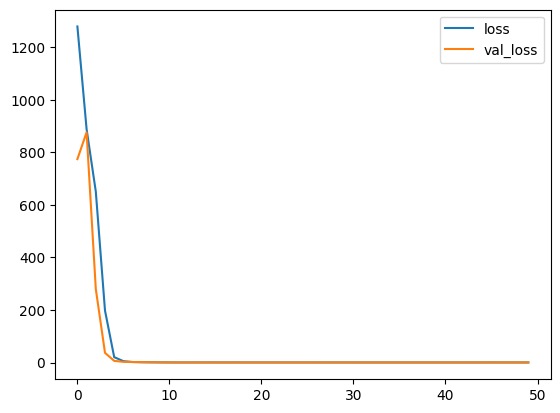

In [36]:
# Plot Training Results
history_seq_df[['loss', 'val_loss']].plot()

In [37]:
# evaluate the model on the test data
test_loss, test_acc = model_sequential.evaluate(X_test, y_test)
print('Test loss:', test_loss)
print('Test accuracy:', test_acc)

6/6 [==============================] - 0s 47ms/step - loss: 0.6061 - accuracy: 0.7458
Test loss: 0.6061385273933411
Test accuracy: 0.7457627058029175


Dari hasil evaluasi model sequential, didapatkan nilai test accuracy sebesar 74%. akurasi tergolong baik, namun masih perlu ditingkatkan agar performa model lebih bagus dalam memprediksi

## 7.2 - Functional API

In [38]:
# Create DataFrame

history_func_df = pd.DataFrame(history_func.history)
history_func_df

,loss,accuracy,val_loss,val_accuracy
0,2.308024,0.636364,6.118762,0.785311
1,2.036303,0.556818,3.102425,0.768362
2,1.957200,0.704545,5.546558,0.779661
3,1.844532,0.693182,4.227076,0.785311
4,1.777275,0.704545,3.267959,0.796610
5,1.700849,0.784091,3.302053,0.796610
6,1.680297,0.727273,3.598958,0.813559
7,1.674368,0.738636,3.671774,0.830508
8,1.606748,0.761364,3.313643,0.796610
9,1.675645,0.693182,3.684524,0.796610


<Axes: >

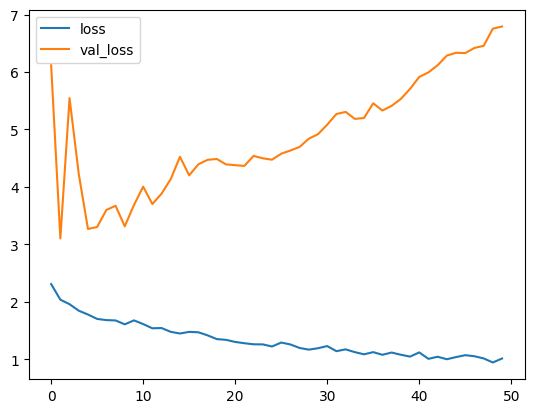

In [39]:
# Plot Training Results
history_func_df[['loss', 'val_loss']].plot()

In [40]:
# Model Evaluation of test-set
test_loss, test_acc = model_functional.evaluate(X_test, y_test)
print('Test loss:', test_loss)
print('Test accuracy:', test_acc)

6/6 [==============================] - 1s 122ms/step - loss: 6.7943 - accuracy: 0.7627
Test loss: 6.794254779815674
Test accuracy: 0.7627118825912476


model functional memiliki loss sebesar 6.974 dan akurasi sebesar 76.7% pada data test. Artinya, model memiliki performa yang cukup baik dalam memprediksi apakah gambar memiliki tumor atau tidak tetapi masih perlu ditingkatkan, model cenderung overfitting

# 9 - Model Improvement

## 9.1 - Sequential API

In [41]:
# Buat objek ImageDataGenerator untuk augmentasi gambar
datagen = ImageDataGenerator(
    rotation_range=10,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    vertical_flip=False,
    fill_mode='nearest')

In [42]:
# Load model VGG16 pre-trained
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

In [43]:
# Tambahkan lapisan output pada model
model_seq = Sequential()
model_seq.add(base_model)
model_seq.add(Flatten())
model_seq.add(Dense(512, activation='relu'))
model_seq.add(Dropout(0.5))
model_seq.add(Dense(2, activation='softmax'))

# Kunci lapisan pre-trained agar tidak terupdate pada pelatihan
for layer in base_model.layers:
    layer.trainable = False

# Compile model
model_seq.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model_seq.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten_2 (Flatten)         (None, 25088)             0         
                                                                 
 dense_5 (Dense)             (None, 512)               12845568  
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_6 (Dense)             (None, 2)                 1026      
                                                                 
Total params: 27,561,282
Trainable params: 12,846,594
Non-trainable params: 14,714,688
_________________________________________________________________


In [44]:
# Fit model dengan data generator
history_seq_imp = model_seq.fit(datagen.flow(X_train, y_train, batch_size=128), 
          validation_data=(X_val, y_val),
          epochs=60)

Epoch 1/60
1/1 [==============================] - 19s 19s/step - loss: 10.7534 - accuracy: 0.4318 - val_loss: 160.6131 - val_accuracy: 0.7079
Epoch 2/60
1/1 [==============================] - 2s 2s/step - loss: 165.2155 - accuracy: 0.6932 - val_loss: 94.1547 - val_accuracy: 0.7079
Epoch 3/60
1/1 [==============================] - 2s 2s/step - loss: 95.5423 - accuracy: 0.6932 - val_loss: 22.3335 - val_accuracy: 0.7079
Epoch 4/60
1/1 [==============================] - 2s 2s/step - loss: 17.9993 - accuracy: 0.7045 - val_loss: 26.8608 - val_accuracy: 0.4494
Epoch 5/60
1/1 [==============================] - 2s 2s/step - loss: 20.1052 - accuracy: 0.5455 - val_loss: 39.0496 - val_accuracy: 0.3708
Epoch 6/60
1/1 [==============================] - 2s 2s/step - loss: 31.3557 - accuracy: 0.4886 - val_loss: 26.1261 - val_accuracy: 0.4270
Epoch 7/60
1/1 [==============================] - 2s 2s/step - loss: 19.3052 - accuracy: 0.5455 - val_loss: 9.2106 - val_accuracy: 0.6404
Epoch 8/60
1/1 [========

In [45]:
# Create DataFrame

history_seq_improve = pd.DataFrame(history_seq_imp.history)
history_seq_improve

,loss,accuracy,val_loss,val_accuracy
0,10.753424,0.431818,160.613098,0.707865
1,165.215500,0.693182,94.154747,0.707865
2,95.542282,0.693182,22.333502,0.707865
3,17.999279,0.704545,26.860771,0.449438
4,20.105190,0.545455,39.049576,0.370787
5,31.355663,0.488636,26.126144,0.426966
6,19.305204,0.545455,9.210598,0.640449
7,9.045861,0.704545,6.528623,0.707865
8,6.698965,0.750000,12.571166,0.707865
9,10.161868,0.704545,15.361007,0.707865


<Axes: >

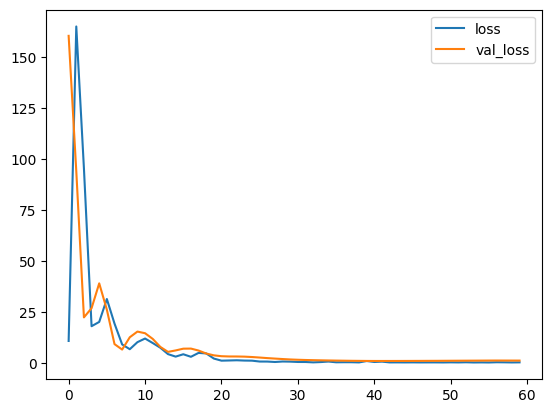

In [46]:
# Plot Training Results
history_seq_improve[['loss', 'val_loss']].plot()

In [47]:
# evaluate the model on the test data
test_loss, test_acc = model_seq.evaluate(X_test, y_test)
print('Test loss:', test_loss)
print('Test accuracy:', test_acc)

6/6 [==============================] - 1s 124ms/step - loss: 1.1559 - accuracy: 0.7119
Test loss: 1.155874490737915
Test accuracy: 0.7118644118309021


sebelum improvement

6/6 [==============================] - 0s 47ms/step - loss: 0.6061 - accuracy: 0.7458

Test loss: 0.6061385273933411
Test accuracy: 0.7457627058029175

terlihat bahwa setelah dilakukan improvement pada model sequential API, terjadi penurunan performa dari sequential API

## 9.2 - Functional API

In [48]:
# Buat objek ImageDataGenerator untuk augmentasi gambar
datagen = ImageDataGenerator(
    rotation_range=10,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    vertical_flip=False,
    fill_mode='nearest')

In [49]:
# Buat input layer dengan shape gambar
input_layer = layers.Input(shape=(224, 224, 3))

In [50]:
# Tambahkan layer-layer pada model
x = layers.Conv2D(32, kernel_size=(3, 3), activation='relu')(input_layer)
x = layers.MaxPooling2D(pool_size=(2, 2))(x)
x = layers.Conv2D(64, kernel_size=(3, 3), activation='relu')(x)
x = layers.MaxPooling2D(pool_size=(2, 2))(x)
x = layers.Flatten()(x)
x = layers.Dense(128, activation='relu')(x)
output_layer = layers.Dense(2, activation='softmax')(x)

# Buat model dengan input dan output layer
model_func = keras.Model(inputs=input_layer, outputs=output_layer)

# Compile model
model_func.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model_func.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d_2 (Conv2D)           (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 111, 111, 32)     0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 54, 54, 64)       0         
 2D)                                                             
                                                                 
 flatten_3 (Flatten)         (None, 186624)            0   

In [51]:
# Fit model dengan data generator
history_func_imp = model_func.fit(datagen.flow(X_train, y_train, batch_size=64), 
          validation_data=(X_val, y_val),
          epochs=50)

Epoch 1/50
2/2 [==============================] - 4s 267ms/step - loss: 1543.7188 - accuracy: 0.3977 - val_loss: 3136.6658 - val_accuracy: 0.7079
Epoch 2/50
2/2 [==============================] - 1s 278ms/step - loss: 2979.4055 - accuracy: 0.6932 - val_loss: 711.0477 - val_accuracy: 0.7079
Epoch 3/50
2/2 [==============================] - 1s 279ms/step - loss: 600.0235 - accuracy: 0.6932 - val_loss: 133.5561 - val_accuracy: 0.4382
Epoch 4/50
2/2 [==============================] - 1s 465ms/step - loss: 157.2854 - accuracy: 0.3750 - val_loss: 159.7809 - val_accuracy: 0.3034
Epoch 5/50
2/2 [==============================] - 2s 444ms/step - loss: 127.3088 - accuracy: 0.3864 - val_loss: 35.2811 - val_accuracy: 0.7079
Epoch 6/50
2/2 [==============================] - 1s 759ms/step - loss: 46.0896 - accuracy: 0.6705 - val_loss: 51.2414 - val_accuracy: 0.6966
Epoch 7/50
2/2 [==============================] - 1s 298ms/step - loss: 48.9991 - accuracy: 0.6818 - val_loss: 33.1330 - val_accuracy: 0

In [52]:
# Create DataFrame

history_func_improve = pd.DataFrame(history_func_imp.history)
history_func_improve

,loss,accuracy,val_loss,val_accuracy
0,1543.718750,0.397727,3136.665771,0.707865
1,2979.405518,0.693182,711.047729,0.707865
2,600.023499,0.693182,133.556107,0.438202
3,157.285355,0.375000,159.780869,0.303371
4,127.308807,0.386364,35.281116,0.707865
5,46.089649,0.670455,51.241421,0.696629
6,48.999107,0.681818,33.133041,0.685393
7,25.415211,0.670455,21.516367,0.696629
8,13.765334,0.647727,15.145648,0.662921
9,7.621687,0.681818,12.548715,0.606742


<Axes: >

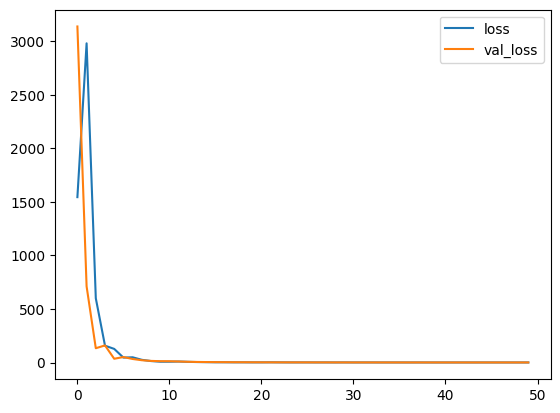

In [53]:
# Plot Training Results
history_func_improve[['loss', 'val_loss']].plot()

In [54]:
# evaluate the model on the test data
test_loss, test_acc = model_functional.evaluate(X_test, y_test)
print('Test loss:', test_loss)
print('Test accuracy:', test_acc)

6/6 [==============================] - 1s 119ms/step - loss: 6.7943 - accuracy: 0.7627
Test loss: 6.794254779815674
Test accuracy: 0.7627118825912476


sebelum improvement

6/6 [==============================] - 1s 122ms/step - loss: 6.7943 - accuracy: 0.7627

Test loss: 6.794254779815674
Test accuracy: 0.7627118825912476

model functional setelah di improvement memiliki nilai loss sebesar 6.79 dan akurasi sebesar 76.7% pada saat diuji dengan data testing. Hal ini menunjukkan bahwa model tidak ada perbedaan yg signifikan dari segi score, tetapi setelah di improvisai, model tergolong goodfit. dan jika dibandingkan, model functional API lebih baik daripada sequential API, akan digunakan metode validasi untuk mengukur performa model

In [55]:
# Tentukan jumlah fold
kfold = KFold(n_splits=5, shuffle=True, random_state=25)

# Inisialisasi array untuk menyimpan hasil evaluasi
cvscores = []

# Loop untuk melakukan cross-validation
for train_index, test_index in kfold.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # Fit the model
    model_functional.fit(datagen.flow(X_train, y_train, batch_size=32), epochs=50, validation_data=(X_test, y_test))

    # Evaluate the model
    scores = model_functional.evaluate(X_test, y_test, verbose=0)
    print("%s: %.2f%%" % (model_functional.metrics_names[1], scores[1]*100))
    cvscores.append(scores[1] * 100)

# Print hasil evaluasi
print("%.2f%% (+/- %.2f%%)" % (np.mean(cvscores), np.std(cvscores)))

Epoch 1/50
9/9 [==============================] - 9s 650ms/step - loss: 6.3129 - accuracy: 0.7102 - val_loss: 4.1857 - val_accuracy: 0.7183
Epoch 2/50
9/9 [==============================] - 4s 429ms/step - loss: 5.1380 - accuracy: 0.6714 - val_loss: 6.4782 - val_accuracy: 0.6761
Epoch 3/50
9/9 [==============================] - 3s 381ms/step - loss: 4.6504 - accuracy: 0.6466 - val_loss: 3.6381 - val_accuracy: 0.7465
Epoch 4/50
9/9 [==============================] - 4s 391ms/step - loss: 3.2517 - accuracy: 0.7420 - val_loss: 2.7922 - val_accuracy: 0.7606
Epoch 5/50
9/9 [==============================] - 5s 557ms/step - loss: 2.8934 - accuracy: 0.7491 - val_loss: 2.8659 - val_accuracy: 0.7887
Epoch 6/50
9/9 [==============================] - 4s 424ms/step - loss: 2.4767 - accuracy: 0.7420 - val_loss: 2.7650 - val_accuracy: 0.7183
Epoch 7/50
9/9 [==============================] - 4s 385ms/step - loss: 2.1527 - accuracy: 0.7986 - val_loss: 2.8009 - val_accuracy: 0.7042
Epoch 8/50
9/9 [====

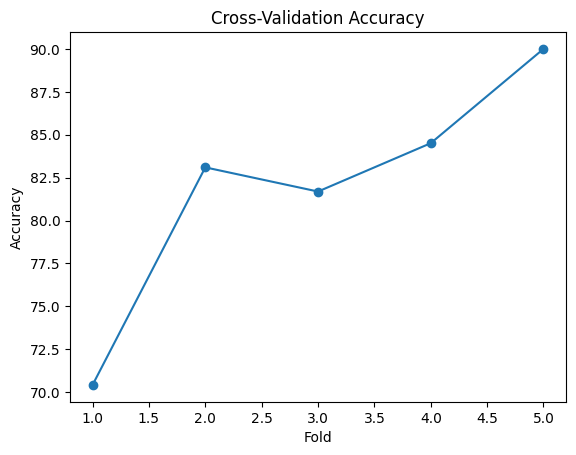

In [56]:
# Buat line plot
plt.plot(np.arange(1, len(cvscores)+1), cvscores, marker='o')
plt.xlabel('Fold')
plt.ylabel('Accuracy')
plt.title('Cross-Validation Accuracy')
plt.show()

dapat dilihat bahwa model memiliki variasi performa yang cukup signifikan di setiap fold. Akurasi tertinggi terjadi pada fold ke-5, namun rata-rata akurasi seluruh fold adalah 81.94% dengan standar deviasi 6.41%

# 10 - Model Saving

In [63]:
# Save ANN Model

model_functional.save('tumor_dataset_model.h5')

In [67]:
# Summary of Model Sequential

model_functional.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten_1 (Flatten)         (None, 25088)             0         
                                                                 
 dense_2 (Dense)             (None, 512)               12845568  
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_3 (Dense)             (None, 256)               131328    
                                                                 
 dense_4 (Dense)             (None, 2)                 514   

In [66]:
# Freeze Model

model_functional.trainable = False
model_functional.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten_1 (Flatten)         (None, 25088)             0         
                                                                 
 dense_2 (Dense)             (None, 512)               12845568  
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_3 (Dense)             (None, 256)               131328    
                                                                 
 dense_4 (Dense)             (None, 2)                 514   